This Notebook created by [Moussa Jamor](https://github.com/JamorMoussa/)

Notebook link (Github): [Introduction to GCN with Pytorch Geometric](https://github.com/JamorMoussa/learn-DeepLearning/blob/main/graph%20neural%20networks/GCN%20-%20Graph%20Convolution%20Networks/Introduction%20to%20Graph%20Neural%20Network%20with%20Pytorch.ipynb)

# Introduction to GCN with Pytorch Geometric

In this notebook we're going to have an introduction, to **Graph Convolution Networks** using **PyTorch Geometic**. Which is a package build with PyTorch framework to deal with **Graph Data**.

> **Note:**
>
> This notebook is based on this [Introduction to Graph Neural Network with Pytorch](https://www.kaggle.com/code/iogbonna/introduction-to-graph-neural-network-with-pytorch), kaggle.

In this notebook, we'll use the **Zachary's karate club** dataset to train our, first **GCN** model. we don't need to download this dataset because, It's available in **PyTorch Geometric**. 

In [182]:
# import libraries: 

import torch
import torch.nn as nn
import torch.optim as optim

from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
import torch_geometric.nn as gnn

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, accuracy_score

## 1. Load and Visualize *KarateClub* Dataset

### 1.1 Load dataset

This dataset, ***KarateClub***, is a graph, so we'll use the **GCN** architecture. Although we could use the **MLP** model, we'd lose a lot of information because of the connections between the nodes.

In [4]:
dataset = KarateClub()

In [7]:
dataset.print_summary()

KarateClub (#graphs=1):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |       34 |      156 |
| std        |      nan |      nan |
| min        |       34 |      156 |
| quantile25 |       34 |      156 |
| median     |       34 |      156 |
| quantile75 |       34 |      156 |
| max        |       34 |      156 |
+------------+----------+----------+


In [8]:
def dataset_info(dataset) -> None:
    print(f"Dataset: {dataset}")
    print(f'Number of graphs in the dataset: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')

In [9]:
dataset_info(dataset)

Dataset: KarateClub()
Number of graphs in the dataset: 1
Number of features: 34
Number of classes: 4


In [76]:
data = dataset[0]

In [95]:
data.x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [96]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

### 1.2 Visuatlize Dataset

In [29]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

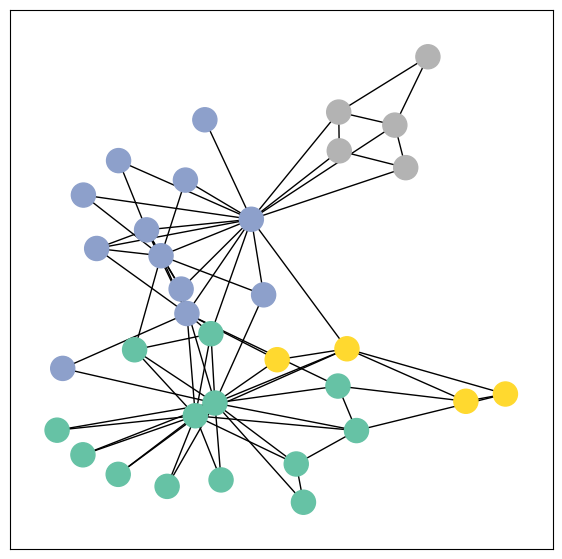

In [75]:
G = to_networkx(data=data, to_undirected=True)

visualize_graph(G, color=data.y)

## 2. Build and Train GCN model 

### 2.1 Build GCN Model

In [226]:
class GCNModel(nn.Module):

    def __init__(self) -> None:
        super(GCNModel, self).__init__()

        self.conv_block = gnn.Sequential('x, edge_index', [
            (gnn.GCNConv(dataset.num_features, 4), 'x, edge_index -> x'),
            nn.ReLU(inplace=True),
            (gnn.GCNConv(4, 4), 'x, edge_index -> x'),
            nn.ReLU(inplace=True)
        ])
        self.classifier = nn.Linear(4, dataset.num_classes)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        out = self.conv_block(input, data.edge_index)
        return self.classifier(out)

In [227]:
model = GCNModel()

In [228]:
model

GCNModel(
  (conv_block): Sequential(
    (0) - GCNConv(34, 4): x, edge_index -> x
    (1) - ReLU(inplace=True): x -> x
    (2) - GCNConv(4, 4): x, edge_index -> x
    (3) - ReLU(inplace=True): x -> x
  )
  (classifier): Linear(in_features=4, out_features=4, bias=True)
)

In [229]:
model(data.x)[:5]

tensor([[ 0.1261,  0.0014,  0.0843,  0.4061],
        [ 0.1348,  0.0019,  0.0927,  0.4229],
        [ 0.1360, -0.0030,  0.0902,  0.4285],
        [ 0.1359, -0.0065,  0.0875,  0.4303],
        [ 0.1245,  0.0312,  0.1046,  0.3842]], grad_fn=<SliceBackward0>)

### 2.2 Define Loss Function and Oprimizer

In [230]:
fn_loss = nn.CrossEntropyLoss()

In [231]:
opt = optim.Adam(model.parameters(), lr=0.002)

### 2.3 Train Model

In [232]:
y_training = []

In [233]:
for epoch in range(1000):

    opt.zero_grad()

    out = model(data.x)

    loss = fn_loss(out, data.y)

    loss.backward()

    opt.step()

    if epoch%100==0:
        with torch.inference_mode():
            out = torch.argmax(out, axis=1)
            y_training.append(out)
            acc = accuracy_score(out, data.y)
            print(f"Epoch: {epoch} | Loss: {loss.item()}|Accuracy: {acc:.2f}%")

Epoch: 0 | Loss: 1.4412527084350586|Accuracy: 0.15%
Epoch: 100 | Loss: 1.183042049407959|Accuracy: 0.65%
Epoch: 200 | Loss: 0.7911558151245117|Accuracy: 0.74%
Epoch: 300 | Loss: 0.41135773062705994|Accuracy: 0.88%
Epoch: 400 | Loss: 0.30913740396499634|Accuracy: 0.88%
Epoch: 500 | Loss: 0.2577175199985504|Accuracy: 0.88%
Epoch: 600 | Loss: 0.18743963539600372|Accuracy: 0.91%
Epoch: 700 | Loss: 0.07639745622873306|Accuracy: 1.00%
Epoch: 800 | Loss: 0.034592367708683014|Accuracy: 1.00%
Epoch: 900 | Loss: 0.019424039870500565|Accuracy: 1.00%


### 2.4 Evaluate Model

In [234]:
out = torch.argmax(model(data.x), axis=1)
out

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [235]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [236]:
print(classification_report(out, data.y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         5

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



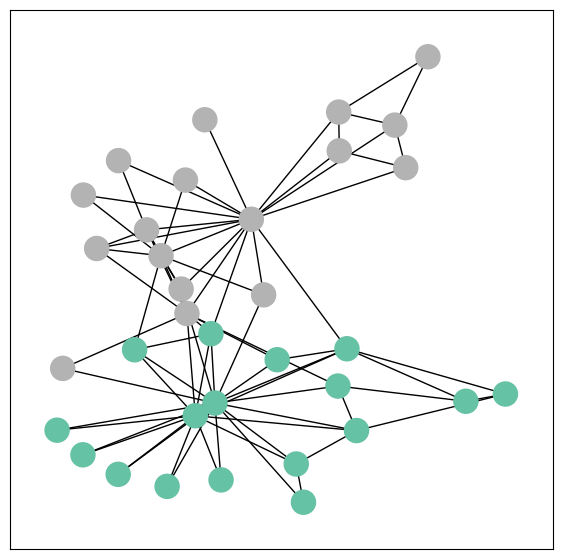

In [240]:
# visualise
visualize_graph(G, color=y_training[2])

In [304]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=y_training[i], cmap="hsv")

fig = plt.figure(figsize=(7,7))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, len(y_training), 1), interval=500, repeat=True)

html = HTML(anim.to_html5_video())

In [305]:
html